In [ ]:
# Cell 1: Imports Yada Yada
import os
import glob
import numpy as np
import pandas as pd
import h5py
import uproot
import awkward as ak
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision, Recall

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,
    precision_recall_curve, average_precision_score
)

print("TensorFlow Version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Num GPUs Available: {len(gpus)}")
    for gpu in gpus:
        print(f"  - {gpu.name}")
else:
    print("No GPU detected. TensorFlow will use the CPU.")

TensorFlow Version: 2.14.0
Num GPUs Available: 1
  - /physical_device:GPU:0


In [ ]:
# Cell 2: Configurations and Helper Functions
from sklearn.model_selection import train_test_split

# Config
selected_variables = [
    "jet1_pt", "jet1_eta", "jet1met_dphi", "jet2met_dphi",
    "met_sig", "mjj", "pTjj", "mbb", "pTbb", "dRjj", "dEtajj",
    "dPhijj", "dRbb", "dEtabb", "dPhibb", "jet2_pt", "jet2_eta"
]

base_dir_LQ      = "/home/sgoswami/monobcntuples/"
signal_masses_LQ = ["500", "1000", "1400", "2000", "2500", "2800"]
base_dir_stop       = "/home/sgoswami/monobcntuples/run3_btag/all"
signal_pattern_stop = os.path.join(base_dir_stop, "singlestop", "basicSel_sT_*.root")
bkg_procs = ["ttbar", "singletop", "dijet", "diboson", "wlnu", "zll", "znunu"]


# Helper Funcc
def importance_shuffle(X, y=None):
    idx = np.random.permutation(len(X))
    Xs = X.iloc[idx].reset_index(drop=True)
    if y is None: return Xs
    return Xs, y[idx]

def filter_ok(paths):
    return [f for f in paths if "_histogram" not in f and "_cutflow" not in f]

def load_root_data(file_list, label, tree_name="sel_tree", max_samples=None):
    dfs = []
    for f in file_list:
        with uproot.open(f) as rf:
            if tree_name not in rf: continue
            arr = rf[tree_name].arrays(selected_variables, library="ak")
        dfs.append(ak.to_dataframe(arr))
    if not dfs: return pd.DataFrame(columns=selected_variables), np.array([])
    combined = pd.concat(dfs, axis=0).reset_index(drop=True)
    if max_samples:
        replace = max_samples > len(combined)
        combined = combined.sample(n=max_samples, replace=replace).reset_index(drop=True)
    else:
        combined = combined.sample(frac=1).reset_index(drop=True)
    return combined, np.full(len(combined), label)

def load_h5_data(file_list, label):
    dfs = []
    for f in file_list:
        with h5py.File(f, "r") as hf:
            cols0 = [n.decode() for n in hf["df/block0_items"][:]]
            vals0 = pd.DataFrame(hf["df/block0_values"][:], columns=cols0)
            cols1 = [n.decode() for n in hf["df/block1_items"][:]]
            vals1 = pd.DataFrame(hf["df/block1_values"][:], columns=cols1)
        dfs.append(pd.concat([vals0, vals1], axis=1)[selected_variables])
    if not dfs: return pd.DataFrame(columns=selected_variables), np.array([])
    combined = pd.concat(dfs, axis=0).reset_index(drop=True)
    return combined, np.full(len(combined), label)


# Sampling Setup
eff_xs = {
    'ttbar': 729.77 * (0.10546 + 0.45623 + 0.54382), 'singletop': 2.0267 + 1.2675 + 36.995 + 22.173,
    'dijet': (2.4331e9*0.00986+2.6450e7*0.01166+2.5461e5*0.01337+4.5532e3*0.01453+
              257.54*0.00947+16.215*0.01110+0.62506*0.01015+0.01964*0.01206),
    'diboson': 1.2974 + 4.661 + 12.079 + 0.02221 + 3.1081 + 0.57762,
    'wlnu': (21745.0*0.14699+21814.0*0.00923+21814.0*0.14722+21814.0*0.14343+
             21815.0*0.00912),
    'zll': (2221.3*0.02494+2221.3*0.12896+2221.4*0.02439+2221.4*0.12920+
            2239.7*0.02487+2239.6*0.12915+2239.6*0.84596),
    'znunu': 448.77 * 0.20291,
}
_total_eff = sum(eff_xs.values())
bkg_probs = {p: xs/_total_eff for p, xs in eff_xs.items()}


# Dataset Preparation Funcc
def prepare_LQ():
    sig_files = []
    for m in signal_masses_LQ:
        sig_files += filter_ok(glob.glob(os.path.join(base_dir_LQ, f"mass_{m}", "basicSel_mass_*.h5")))
    sig_df, sig_lbl = load_h5_data(sig_files, 1)
    S = len(sig_df)
    bkg_counts = {p: int(round(S * bkg_probs[p])) for p in bkg_procs}
    diff = S - sum(bkg_counts.values()); bkg_counts[bkg_procs[-1]] += diff
    bkg_parts, bkg_files_map = [], {}
    for proc in bkg_procs:
        n_req = bkg_counts[proc]
        if n_req == 0: continue
        if proc == 'wlnu':
            dirs = ['wenu_mc20e','wmunu_mc20e','wtaunu_mc20e']
            files = sum((glob.glob(os.path.join(base_dir_LQ, d, "*.h5")) for d in dirs), [])
        elif proc == 'zll':
            dirs = ['zee_mc20e','zmumu_mc20e','ztautau_mc20e']
            files = sum((glob.glob(os.path.join(base_dir_LQ, d, "*.h5")) for d in dirs), [])
        else: files = glob.glob(os.path.join(base_dir_LQ, f"{proc}_mc20e", "*.h5"))
        files = filter_ok(files)
        bkg_files_map[proc] = files
        if not files: continue
        df_all, _ = load_h5_data(files, 0)
        if len(df_all) == 0: continue
        replace = n_req > len(df_all)
        df_samp = df_all.sample(n=n_req, replace=replace).reset_index(drop=True)
        bkg_parts.append(df_samp)
    bkg_df = pd.concat(bkg_parts, axis=0).reset_index(drop=True)
    bkg_df = importance_shuffle(bkg_df)
    X_LQ = pd.concat([sig_df, bkg_df], axis=0).reset_index(drop=True)
    y_LQ = np.concatenate([sig_lbl, np.zeros(len(bkg_df), dtype=int)])
    return importance_shuffle(X_LQ, y_LQ), sig_files, bkg_files_map

def prepare_stop():
    sig_files = filter_ok(glob.glob(signal_pattern_stop))
    sig_df, sig_lbl = load_root_data(sig_files, 1)
    S = len(sig_df)
    bkg_counts = {p: int(round(S * bkg_probs[p])) for p in bkg_procs}
    diff = S - sum(bkg_counts.values()); bkg_counts[bkg_procs[-1]] += diff
    bkg_parts, bkg_files_map = [], {}
    for proc in bkg_procs:
        n_req = bkg_counts[proc]
        if n_req == 0: continue
        files = filter_ok(glob.glob(os.path.join(base_dir_stop, proc, f"basicSel_{proc}.root")))
        bkg_files_map[proc] = files
        if not files: continue
        df_p, _ = load_root_data(files, 0, max_samples=n_req)
        bkg_parts.append(df_p)
    bkg_df = pd.concat(bkg_parts, axis=0).reset_index(drop=True)
    bkg_df = importance_shuffle(bkg_df)
    X_stop = pd.concat([sig_df, bkg_df], axis=0).reset_index(drop=True)
    y_stop = np.concatenate([sig_lbl, np.zeros(len(bkg_df), dtype=int)])
    return importance_shuffle(X_stop, y_stop), sig_files, bkg_files_map


# Final Data Loading and Splitting
(X_LQ, y_LQ), lq_sig_files, lq_bkg_files = prepare_LQ()
(X_stop, y_stop), stop_sig_files, stop_bkg_files = prepare_stop()

# Loading Summary
print("--- Files Loaded Summary ---")
print("\nLQ Signal Files:")
for f in sorted(lq_sig_files): print(f"  {f}")
print("\nStop Signal Files:")
for f in sorted(stop_sig_files): print(f"  {f}")
print("\nLQ Background Files by Process:")
for proc, files in lq_bkg_files.items():
    if not files: continue
    print(f"  Process: {proc}")
    for f in sorted(files): print(f"    {f}")
print("\nStop Background Files by Process:")
for proc, files in stop_bkg_files.items():
    if not files: continue
    print(f"  Process: {proc}")
    for f in sorted(files): print(f"    {f}")
print("----------------------------\n")


X_full_df = pd.concat([X_LQ, X_stop], axis=0).reset_index(drop=True)
y_full = np.concatenate([y_LQ, y_stop])
X_full_df, y_full = importance_shuffle(X_full_df, y_full)

print(f"Combined dataset shape: {X_full_df.shape}")
print(f"Combined class distribution: {np.bincount(y_full)}")

X_train_df, X_val_df, y_train, y_val = train_test_split(
    X_full_df, y_full, test_size=0.2, random_state=42, stratify=y_full
)

print(f"\nTrain set shape: {X_train_df.shape}")
print(f"Validation set shape:  {X_val_df.shape}")

--- Files Loaded Summary ---

LQ Signal Files:
  /home/sgoswami/monobcntuples/mass_1000/basicSel_mass_1000.h5
  /home/sgoswami/monobcntuples/mass_1400/basicSel_mass_1400.h5
  /home/sgoswami/monobcntuples/mass_2000/basicSel_mass_2000.h5
  /home/sgoswami/monobcntuples/mass_2500/basicSel_mass_2500.h5
  /home/sgoswami/monobcntuples/mass_2800/basicSel_mass_2800.h5
  /home/sgoswami/monobcntuples/mass_500/basicSel_mass_500.h5

Stop Signal Files:
  /home/sgoswami/monobcntuples/run3_btag/all/singlestop/basicSel_sT_bC1_1000_102_100.root
  /home/sgoswami/monobcntuples/run3_btag/all/singlestop/basicSel_sT_bC1_1000_202_200.root
  /home/sgoswami/monobcntuples/run3_btag/all/singlestop/basicSel_sT_tN1_1000_102_100.root
  /home/sgoswami/monobcntuples/run3_btag/all/singlestop/basicSel_sT_tN1_1000_202_200.root
  /home/sgoswami/monobcntuples/run3_btag/all/singlestop/basicSel_sT_tN1_1000_3_1.root

LQ Background Files by Process:
  Process: ttbar
    /home/sgoswami/monobcntuples/ttbar_mc20e/basicSel_ttbar_m

Data integrity check:
                 count         mean          std         min         25%  \
jet1_pt       950790.0  1258.569342  1081.494234  150.000297  387.928941   
jet1_eta      950790.0    -0.000360     0.795444   -2.399972   -0.511694   
jet1met_dphi  950790.0     2.623695     0.683634    0.400016    2.595317   
jet2met_dphi  950790.0     1.595077     0.930451    0.400004    0.686199   
met_sig       950790.0    12.098392     7.317306    0.031021    5.064415   
mjj           950790.0  2199.399658  2303.156982   -0.099000  273.995491   
pTjj          950790.0   565.390930   359.286743   -0.099000  335.409119   
mbb           950790.0   159.867355   508.424377   -0.099000   -0.099000   
pTbb          950790.0   171.784195   497.804535   -0.099000   -0.099000   
dRjj          950790.0    -3.011915    22.778856  -99.000000    1.438978   
dEtajj        950790.0    -5.272711    22.255291  -99.000000   -0.851754   
dPhijj        950790.0    -5.263987    22.335670  -99.000000   -2.

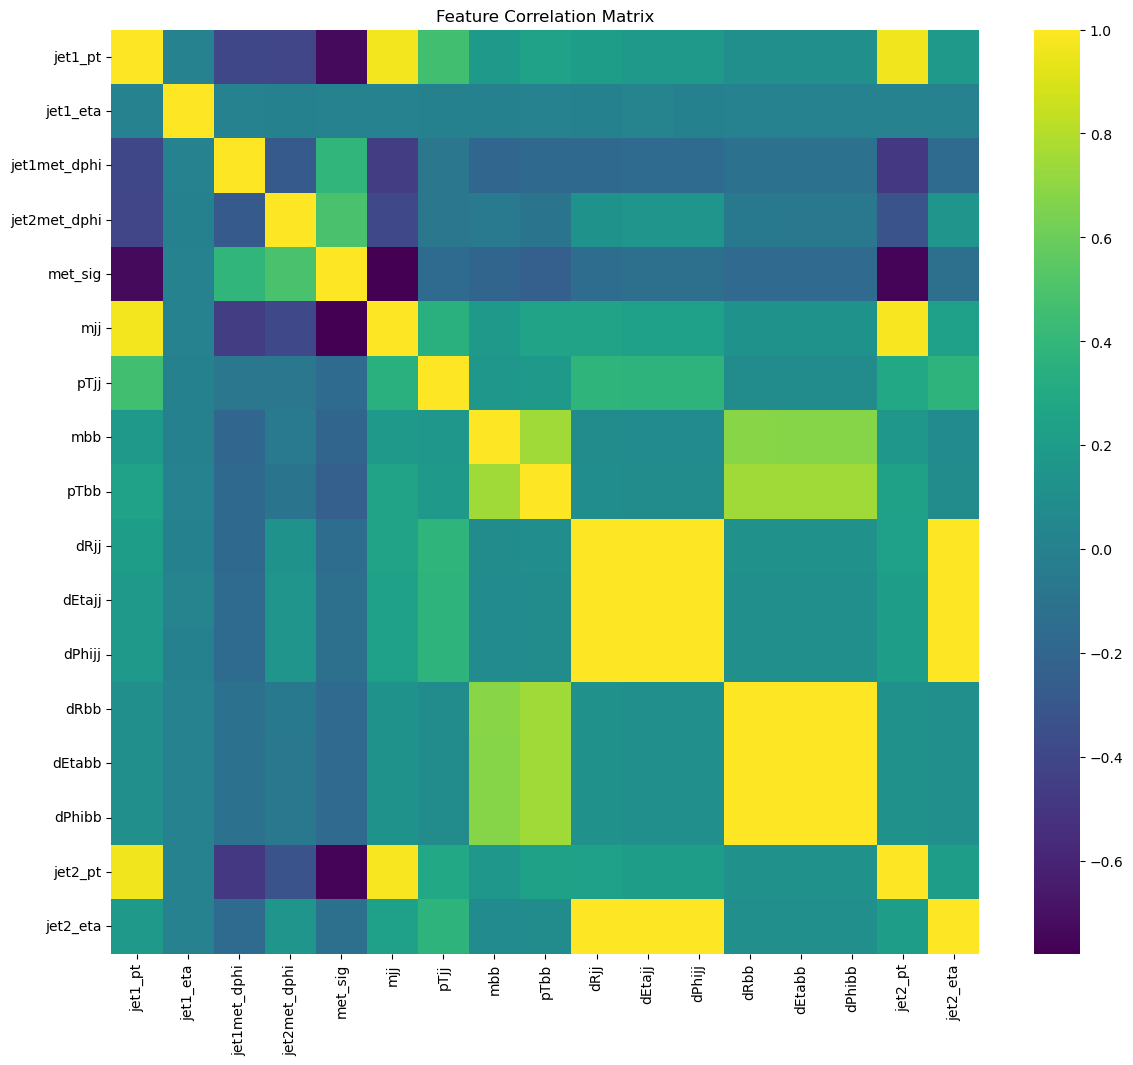

In [4]:
# Cell 3: Data Analysis & Visualization
import seaborn as sns

# Data integrity check
print("Data integrity check:")
print(X_train_df.describe().transpose())
print("\nChecking for NaN values:")
print(X_train_df.isna().sum())

# Feature Correlation Matrix
plt.figure(figsize=(14, 12))
correlation_matrix = X_train_df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='viridis')
plt.title('Feature Correlation Matrix')
plt.show()

In [ ]:
# Cell 4: Define Model, Optimizer, and Callbacks

def build_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, kernel_initializer='he_normal', activation='gelu'),
        BatchNormalization(),
        Dense(64, kernel_initializer='he_normal', activation='gelu'),
        BatchNormalization(),
        Dense(32, kernel_initializer='he_normal', activation='gelu'),
        BatchNormalization(),
        Dense(1, kernel_initializer='he_normal', activation='sigmoid'),
    ])
    return model

# saving to .keras (old loader causes issues)

lr          = 5e-5
epochs      = 150
batch_size  = 512

metric_list = [
    AUC(name='auc'),
    'accuracy',
    Precision(name='precision'),
    Recall(name='recall')
]

callbacks = [
    EarlyStopping(
        monitor='val_auc',
        patience=20,
        mode='max',
        verbose=1,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_auc',
        factor=0.2,
        patience=7,
        mode='max',
        verbose=1,
        min_lr=1e-7
    ),
]

model = build_model(input_dim=X_train_df.shape[1])

model.compile(
    optimizer=Adam(learning_rate=lr),
    loss='binary_crossentropy',
    metrics=metric_list
)

model.summary()


2025-07-03 13:12:47.761031: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22157 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2304      
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_2 (Bat  (None, 32)                1

In [6]:
# Cell 5: Train Model

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df.values)
X_val = scaler.transform(X_val_df.values)

print(f"Starting training with LR={lr}, BS={batch_size}, Epochs={epochs}")
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)
model.save("best_model.keras", save_format="keras")

Starting training with LR=5e-05, BS=512, Epochs=150
Epoch 1/150


2025-07-03 13:13:01.107734: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7d82702836f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-03 13:13:01.107766: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-07-03 13:13:01.137423: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-03 13:13:01.211277: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-07-03 13:13:01.317432: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1858/1858 [==============================] - 15s 6ms/step - loss: 0.1144 - auc: 0.9918 - accuracy: 0.9621 - precision: 0.9549 - recall: 0.9700 - val_loss: 0.0533 - val_auc: 0.9973 - val_accuracy: 0.9839 - val_precision: 0.9769 - val_recall: 0.9913 - lr: 5.0000e-05
Epoch 2/150
1858/1858 [==============================] - 10s 5ms/step - loss: 0.0511 - auc: 0.9972 - accuracy: 0.9843 - precision: 0.9789 - recall: 0.9899 - val_loss: 0.0488 - val_auc: 0.9974 - val_accuracy: 0.9848 - val_precision: 0.9785 - val_recall: 0.9915 - lr: 5.0000e-05
Epoch 3/150
1858/1858 [==============================] - 10s 5ms/step - loss: 0.0488 - auc: 0.9973 - accuracy: 0.9848 - precision: 0.9798 - recall: 0.9899 - val_loss: 0.0475 - val_auc: 0.9975 - val_accuracy: 0.9852 - val_precision: 0.9798 - val_recall: 0.9908 - lr: 5.0000e-05
Epoch 4/150
1858/1858 [==============================] - 11s 6ms/step - loss: 0.0481 - auc: 0.9973 - accuracy: 0.9849 - precision: 0.9799 - recall: 0.9901 - val_loss: 0.0470 - val_a

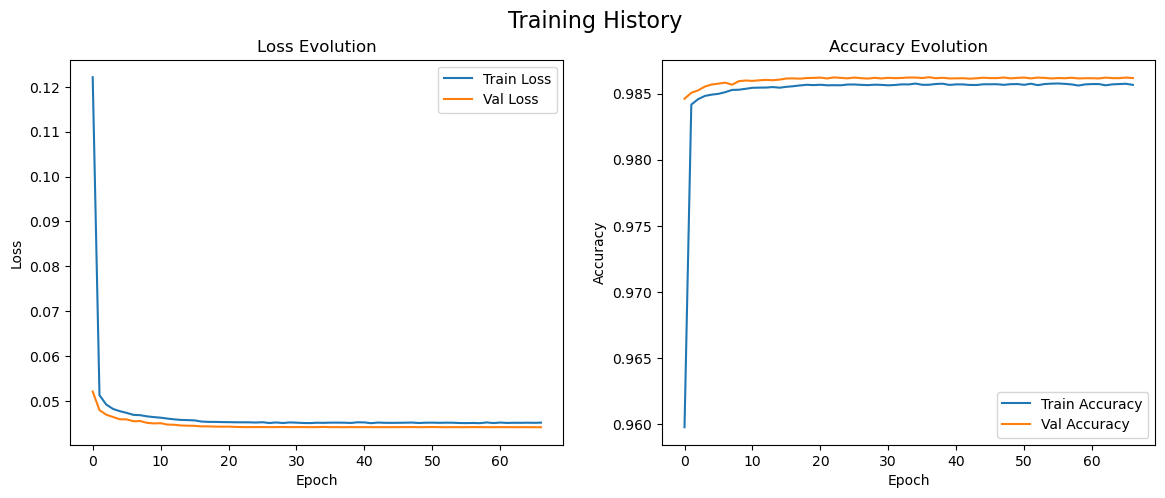

7429/7429 [==============================] - 7s 899us/step


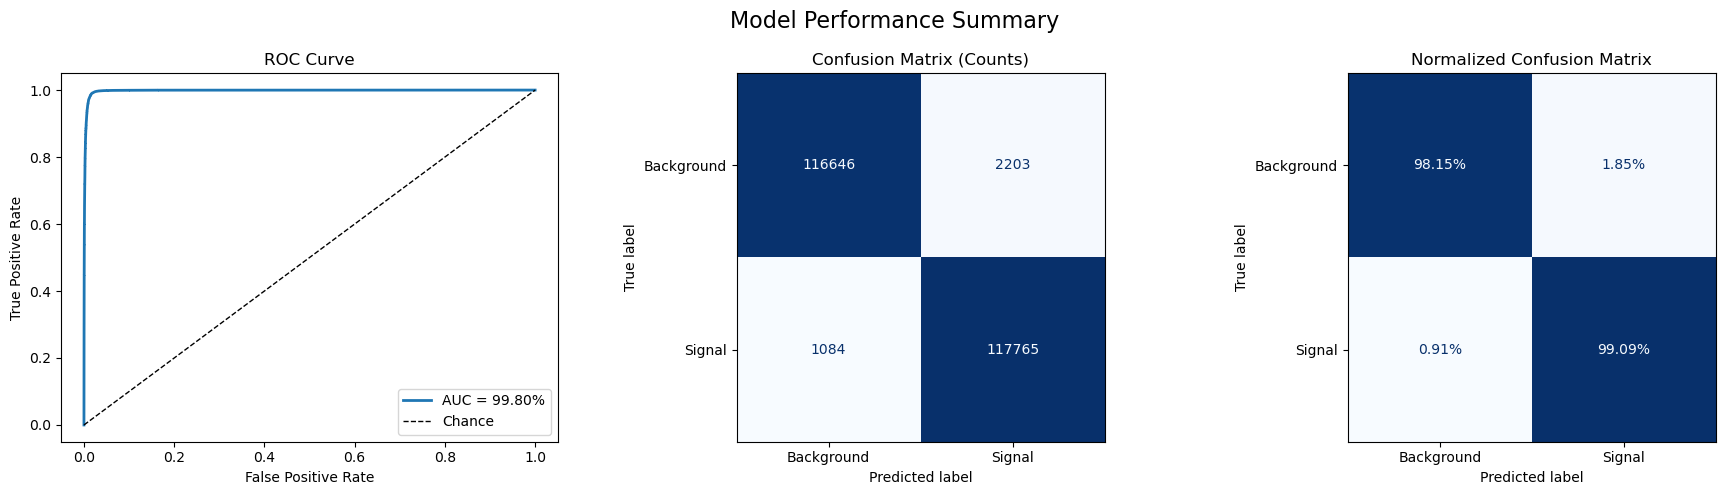

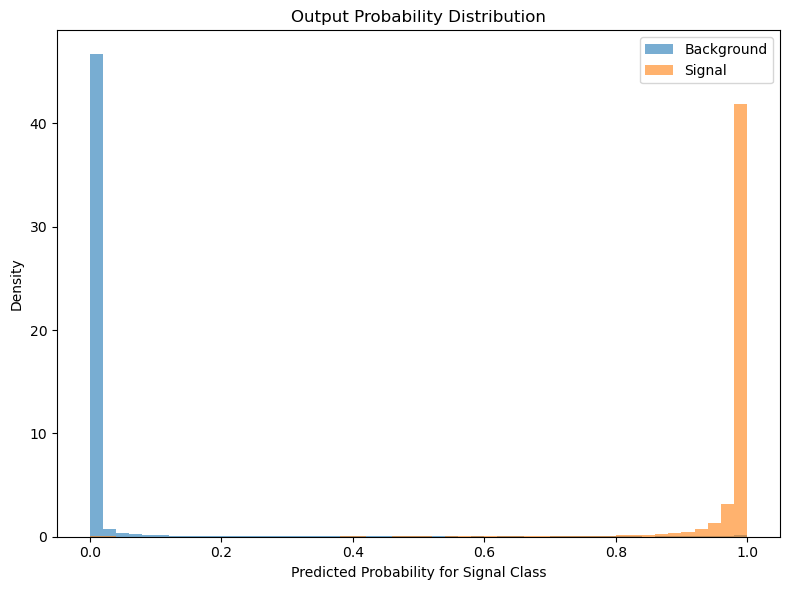

In [ ]:
# Cell 6: Evaluate Model and Plot Results
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
# Plot Loss and Accuracy vs. Epoch
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Training History', fontsize=16)

ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Val Loss')
ax1.set_title('Loss Evolution')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history.history['accuracy'], label='Train Accuracy')
ax2.plot(history.history['val_accuracy'], label='Val Accuracy')
ax2.set_title('Accuracy Evolution')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

y_pred_probs = model.predict(X_val).squeeze()
y_pred_class = (y_pred_probs > 0.5).astype(int)

y_pred_class = (y_pred_probs > 0.5).astype(int)
fpr, tpr, _ = roc_curve(y_val, y_pred_probs)
roc_auc = auc(fpr, tpr)
cm = confusion_matrix(y_val, y_pred_class)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Model Performance Summary', fontsize=16)

# Plot 1: ROC Curve
ax1.plot(fpr, tpr, label=f'AUC = {roc_auc*100:.2f}%', lw=2)
ax1.plot([0, 1], [0, 1], 'k--', lw=1, label='Chance')
ax1.set_title('ROC Curve')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc='lower right')

# Plot 2: Confusion Matrix (Raw Counts)
disp1 = ConfusionMatrixDisplay(cm, display_labels=['Background', 'Signal'])
disp1.plot(ax=ax2, cmap='Blues', colorbar=False, values_format='d')
ax2.set_title('Confusion Matrix (Counts)')

# Plot 2A: Normalized Confusion Matrix (Percentages)
disp2 = ConfusionMatrixDisplay(cm_norm, display_labels=['Background', 'Signal'])
disp2.plot(ax=ax3, cmap='Blues', colorbar=False, values_format='.2%')
ax3.set_title('Normalized Confusion Matrix')

plt.tight_layout()
plt.show()

# Plot 3: Plot Output Probability Distribution
plt.figure(figsize=(8, 6))
plt.hist(y_pred_probs[y_val==0], bins=50, alpha=0.6, label='Background', density=True)
plt.hist(y_pred_probs[y_val==1], bins=50, alpha=0.6, label='Signal', density=True)
plt.xlabel('Predicted Probability for Signal Class')
plt.ylabel('Density')
plt.title('Output Probability Distribution')
plt.legend()
plt.tight_layout()
plt.show()

--- Calculating and Plotting Feature Importance ---
Baseline Validation AUC: 0.9980


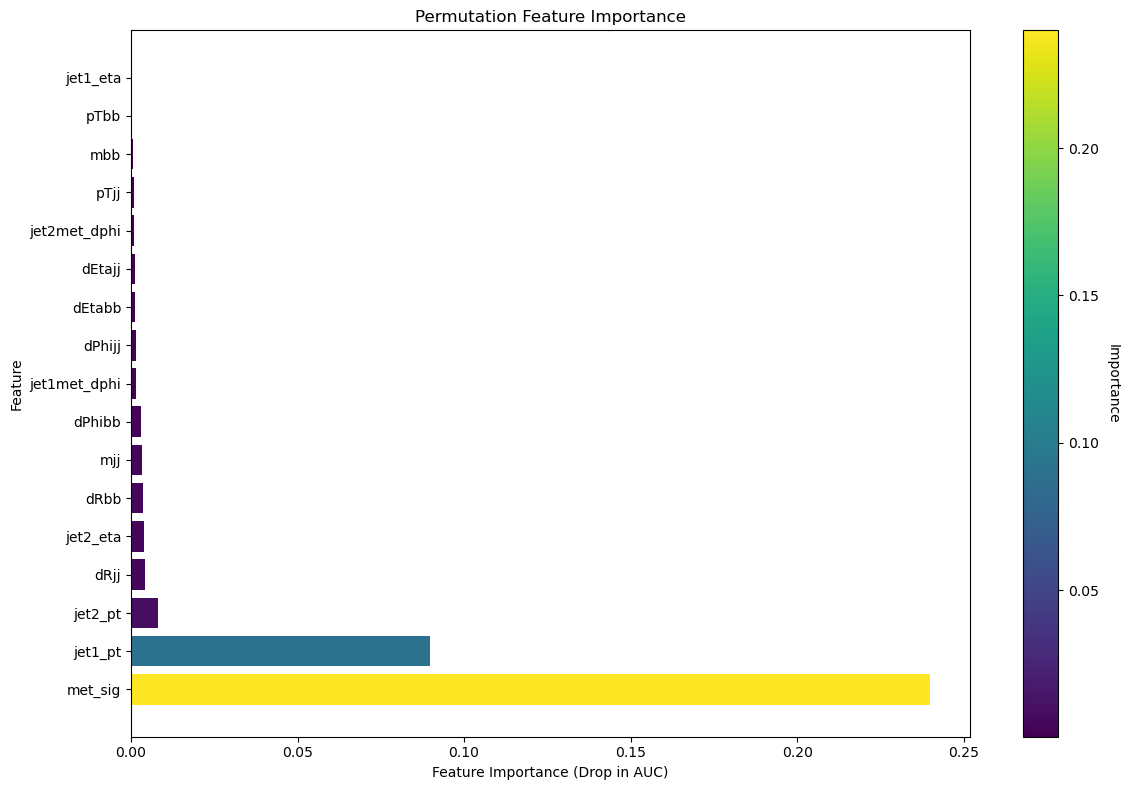

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import tensorflow as tf
from sklearn.metrics import roc_auc_score

print("--- Calculating and Plotting Feature Importance ---")

model = tf.keras.models.load_model('best_model.keras')

y_pred_baseline = model.predict(X_val, batch_size=batch_size, verbose=0).squeeze()
baseline_auc = roc_auc_score(y_val, y_pred_baseline)
print(f"Baseline Validation AUC: {baseline_auc:.4f}")

importances = []

for i in range(X_val.shape[1]):
    X_val_permuted = X_val.copy()
    np.random.shuffle(X_val_permuted[:, i])

    y_pred_permuted = model.predict(X_val_permuted, batch_size=batch_size, verbose=0).squeeze()
    permuted_auc = roc_auc_score(y_val, y_pred_permuted)

    feature_importance = baseline_auc - permuted_auc
    importances.append(feature_importance)


importance_df = pd.DataFrame({
    'feature': selected_variables,
    'importance': importances
}).sort_values(by='importance', ascending=True)


import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))

cmap = plt.get_cmap('viridis')
norm = plt.Normalize(
    vmin=importance_df['importance'].min(),
    vmax=importance_df['importance'].max()
)


ax.barh(
    importance_df['feature'],
    importance_df['importance'],
    color=cmap(norm(importance_df['importance']))
)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Importance', rotation=270, labelpad=15)

ax.set_xlabel("Feature Importance (Drop in AUC)")
ax.set_ylabel("Feature")
ax.set_title("Permutation Feature Importance")
ax.invert_yaxis()

fig.tight_layout()
plt.show()